In [3]:
import pandas as pd
import numpy as np
import math

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geopandas as gpd
from shapely.geometry import Point

from scipy.interpolate import griddata

In [4]:
### Import file 2
gsas_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Science\Geo Data\Saudi Arabia\Jabal Al Hasir\GSAS_GM_094C_Quadrangle_Geochemical_Data.xlsx"
#gsas_filepath = "/Users/thowe/MinersAI Dropbox/Science/Geo Data/Saudi Arabia/Jabal Al Hasir/GSAS_GM_094C_Quadrangle_Geochemical_Data.xlsx"

gsas_raw_data = pd.read_excel(gsas_filepath, sheet_name="DS_RGP_GSAS_GM_094C")
print('File imported successfully')
gsas_raw_data.head(5)

File imported successfully


,Project Code,GSAS,Project Name,Geochemical Survey Arabian Shield,Unnamed: 4,Analyte,Br,Cl,Cr,Hf,...,Sb,Se,Ag,B,Sn,F,N,S,TC,LOI
0,Geologic Quad number,GM-94,Geologic Quad name,Jabal Al Hasir,NaN,Extraction_Code,NONE,NONE,NONE,NONE,...,AR,MAC,NONE,NONE,NONE,CFU,NONE,NONE,NONE,NONE
1,Sample Preparation Manual,Version 1.1,Chemical Analysis Manual,Version 1.1,NaN,Instrument_Code,XRFS-WD,XRFS-WD,XRFS-WD,XRFS-WD,...,AFS,AFS,ES,ES,ES,ISE,GC,IRS,IRS,GR
2,Organised by,Saudi Geological Survey,Conducted by,China Geological Survey,NaN,Unit,mg/kg,mg/kg,mg/kg,mg/kg,...,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,%,%
3,Sample Field Number,Smaple Code,Lab Sample Number,Longitude,Latitude,DL,0.45,6,2,0.15,...,0.05,0.01,0.012,1,0.2,38.2,10,10,0.01,NaN
4,421911AD001,GSAS / GM-94 / 421911AD001,HT231230001,42.772083,19.99388,NaN,1.4195,62.743,47.29,3.49742,...,0.422,0.2038,0.036737,16.64191,1.402524,487.1,89.39,124.6,0.6725,3.81


#### <u>Cleaning Data:</u>

- Combining relevant header rows, dropping all unnecessary header/metadata info
- Identify rows in raw data file that contain the unit labels
    - Remove whitespaces
    - Drop the 5th index (empty analyte column)

- Iterate through all column labels and apply appropriate conversions to get all to ppm
- Convert all numeric columns to float64 dtype

In [5]:
### Clean data

### Set custom headers, drop header rows, and reset index
gsas_columns_part1 = gsas_raw_data.iloc[3, 0:5].tolist()
gsas_data = gsas_raw_data.copy()
gsas_columns = (
    gsas_columns_part1 + gsas_data.columns[len(gsas_columns_part1) :].tolist()
)
print("length of column names:", len(gsas_columns))

# Assign the new column names to the DataFrame
gsas_data.columns = gsas_columns
gsas_data.columns = gsas_data.columns.str.strip()  # Strip any whitespace
print("number of data columns:", len(gsas_data.columns))

# Drop header rows and reset index, drop analyte column
gsas_data = gsas_data.iloc[4:].reset_index(drop=True)
gsas_data = gsas_data.drop(gsas_data.columns[5], axis=1)

print("columns1 =", gsas_columns_part1)
print("Total columns in processed data:", gsas_data.shape[1])

# Identify column labels
gsas_labels = gsas_raw_data.iloc[2].astype(str).fillna("")  # Row with the units
gsas_labels = gsas_labels.str.strip()  # Remove leading/trailing whitespace
gsas_labels = gsas_labels.drop(gsas_labels.index[5])

# Iterate through all column labels and apply appropriate conversions
for col_index, unit in enumerate(gsas_labels):
    if unit == "%":
        # Convert % to ppm (multiply by 10000)
        gsas_data.iloc[:, col_index] = (
            gsas_data.iloc[:, col_index].astype(float) * 10000
        )
        #print(f"Converted column {gsas_data.columns[col_index]} from % to ppm.")
    elif unit == "ng/g":
        # Convert ng/g to ppm 
        gsas_data.iloc[:, col_index] = gsas_data.iloc[:, col_index].astype(float) / 1000
        #print(f"Converted column {gsas_data.columns[col_index]} from ng/g to ppm.")
    elif unit == "mg/kg":
        pass
        # mg/kg is equivalent to ppm, no conversion needed
        #print(
        #    f"Column {gsas_data.columns[col_index]} is already in ppm (mg/kg). No conversion applied."
        #)
    else:
        pass
        # Handle columns with no recognized unit or no conversion needed
        #print(
        #    f"Column {gsas_data.columns[col_index]} has unrecognized or no unit. Skipped conversion."
        #)

# Print a summary of the updated columns
print("Unit conversion completed.")

# Convert all data columns to numeric data type
for col in gsas_data.columns[3:]:
    gsas_data[col] = pd.to_numeric(gsas_data[col], errors="coerce")
print("Converted all columns from column 3 onward to numeric data type.")

print(gsas_data.columns)


length of column names: 63
number of data columns: 63
columns1 = ['Sample Field Number', 'Smaple Code', 'Lab Sample Number', 'Longitude', 'Latitude']
Total columns in processed data: 62
Unit conversion completed.
Converted all columns from column 3 onward to numeric data type.
Index(['Sample Field Number', 'Smaple Code', 'Lab Sample Number', 'Longitude',
       'Latitude', 'Br', 'Cl', 'Cr', 'Hf', 'P', 'Rb', 'Ti', 'Zr', 'SiO2',
       'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn', 'Sr', 'V', 'Zn', 'MgO', 'CaO',
       'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu', 'Ga', 'In', 'Li', 'Mo', 'Nb',
       'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I', 'Ta', 'W', 'Re', 'Au', 'Ir',
       'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se', 'Ag', 'B', 'Sn', 'F', 'N',
       'S', 'TC', 'LOI'],
      dtype='object')


### *Note: no data values below DL, function broken for this dataset - run first cell down to define histogram function*

In [6]:
def calculate_below_detection_percentage(
    df: pd.DataFrame, dl_row_indices: list
) -> dict:
    """
    Calculates the percentage of values below the detection limit (DL) for each column in the DataFrame.

    Parameters:
    - df: Input DataFrame containing numerical data with possible values below DL.
    - dl_row_indices: List of numerical row indices corresponding to DL rows in the DataFrame.

    Returns:
    - A dictionary with column names as keys and the percentage below DL as values.
    """
    # Extract the DL rows from the DataFrame and compute their combined DL values
    detection_limits = (
        df.iloc[dl_row_indices]
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0)
        .sum(axis=0)
    )

    # Initialize a dictionary to store results
    below_dl_percentage = {}

    # Iterate over columns starting from index 3 (assuming first 3 are non-numeric metadata)
    for col_index in range(3, df.shape[1]):
        col_name = df.columns[col_index]
        dl_value = detection_limits[col_name]

        # Count the number of values below the DL
        below_dl_count = (df.iloc[:, col_index] < dl_value).sum()

        # Calculate the percentage below DL
        below_dl_percentage[col_name] = (below_dl_count / len(df)) * 100

    return below_dl_percentage


def plot_histograms(df, elements, bins=20, lower_cutoff=None, upper_cutoff=None):

    """

    Plots histograms for selected elements with optional cutoff for outliers.


    Parameters:

    - df: DataFrame containing geochemical data.

    - elements: List of column names corresponding to the elements.

    - bins: Number of bins for the histograms.

    - lower_cutoff: Lower cutoff as a decimal percentage (e.g., 0.01 for 1st percentile).

    - upper_cutoff: Upper cutoff as a decimal percentage (e.g., 0.99 for 99th percentile).

    """

    num_elements = len(elements)

    cols = 3  # Number of columns in the subplot grid

    rows = math.ceil(num_elements / cols)  # Calculate required rows dynamically


    plt.figure(figsize=(cols * 4, rows * 3))  # Adjust figure size based on grid


    for i, element in enumerate(elements, start=1):

        plt.subplot(rows, cols, i)  # Adjust grid dynamically

        if element in df.columns:

            data = df[element].dropna()  # Remove NaN values


            # Apply lower and/or upper cutoffs if defined

            if lower_cutoff is not None:

                lower_bound = np.percentile(data, lower_cutoff * 100)

                data = data[data >= lower_bound]

            if upper_cutoff is not None:

                upper_bound = np.percentile(data, upper_cutoff * 100)

                data = data[data <= upper_bound]


            plt.hist(data, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)

            plt.title(f"Distribution of {element}", fontsize=12)

            plt.xlabel(f"{element} Concentration (ppm)", fontsize=10)

            plt.ylabel("Frequency", fontsize=10)

            plt.xticks(rotation=45)  # Rotate x-axis tick labels for readability

        else:

            plt.title(f"{element} not found in dataset", fontsize=12)

            plt.axis("off")  # Hide axes for missing data


    plt.tight_layout()  # Adjust spacing

    plt.show()  

In [ ]:
### Calculate + plot below detection limit percentage

# Assuming `gsas_raw_data` and `gsas_data` are loaded as in your code
dl_rows = [3]
below_dl_results = calculate_below_detection_percentage(gsas_data, dl_row_indices=dl_rows)

# Print results
for column, percentage in below_dl_results.items():
    print(f"{column}: {percentage:.2f}% below DL")\
    

# Convert the results to two lists for plotting
columns = list(below_dl_results.keys())
percentages = list(below_dl_results.values())

# Plot the bar chart
plt.figure(figsize=(10, 4))
plt.bar(columns, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Element (Columns)", fontsize=12)
plt.ylabel("Percentage Below Detection Limit (%)", fontsize=12)
plt.title("Percentage of Values Below Detection Limit per Column", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate column names for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()

In [ ]:
### Drop columns with n percentage below detection limit

# Calculate percentage below detection limit
below_dl_results = calculate_below_detection_percentage(
    gsas_data, gsas_raw_data.iloc[5], gsas_raw_data.iloc[6]
)

# Drop columns exceeding the threshold percentage below DL

threshold_below_dl = 90

columns_to_drop = [
    col
    for col, percentage in below_dl_results.items()
    if percentage > threshold_below_dl
]
gsas_data = gsas_data.drop(columns=columns_to_drop)

# Print the columns that were dropped
print(f"Columns dropped due to exceeding {threshold_below_dl}% below DL:")
print(columns_to_drop)

# Ensure no columns with constant values remain
gsas_data = gsas_data.loc[:, gsas_data.nunique() > 1]

---

#### <u>Plot histograms of elements/compounds of interest</u>

- Define upper and lower cutoff to mitigate outliers skewing visualization
<br />
<br />
- Cu/Zn/Au/Ag: base/precious metals
- Cr/Ti/MgO: mafic indicators
- Li: critical mineral
- Al2O3: felsic indicator
<br />
<br />
- Histograms broadly show that the region is felsic-dominated, but contains regions of mafic to ultramafic rocks. Low precious metals and low to moderate base metals.

In [7]:
### Create Al2O3/TiO2 ratio
# Calculate TiO₂ from Ti
gsas_data["TiO2"] = gsas_data["Ti"] * 1.67

# Calculate the Al2O3/TiO2 ratio
gsas_data["Al2O3/TiO2"] = gsas_data["Al2O3"] / gsas_data["TiO2"]

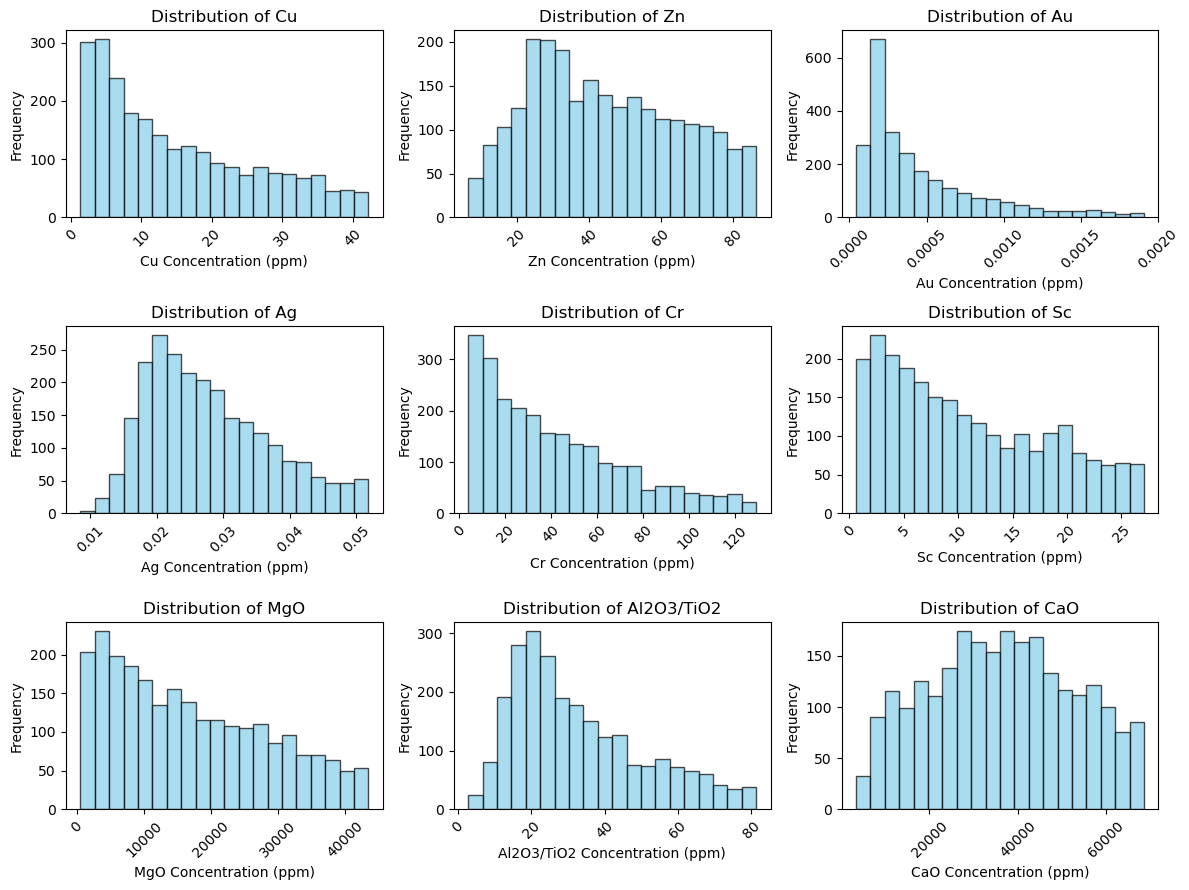

In [8]:
### Histograms

# Define the precious and base metals to plot
precious_base_metals = ["Cu", "Zn", "Au", "Ag", "Cr", "Sc", "MgO", "Al2O3/TiO2", "CaO"]

# LOOK AT Sr, Sc?

# Call the function with your data
plot_histograms(gsas_data, precious_base_metals, bins=20, lower_cutoff=0, upper_cutoff=0.9)

---

#### <u>Create dataset-wide correlation plot</u>

Statistics:

Average correlation: 0.1289761227165652
Max correlation: 1.000000000000004
Min correlation: -0.913347123293398


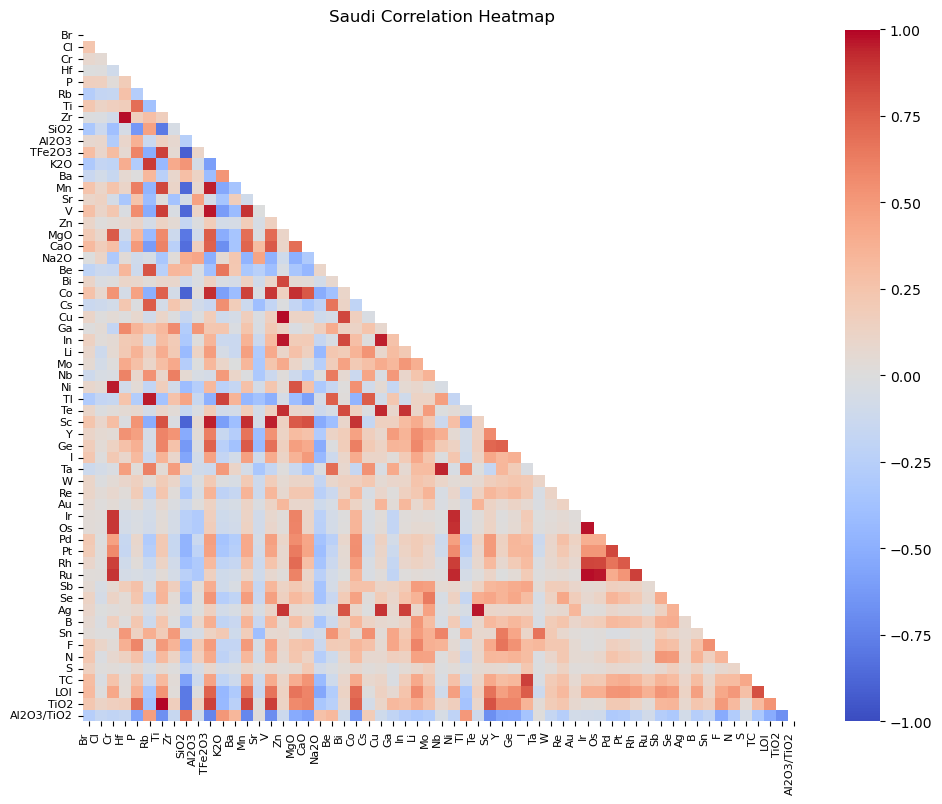

In [9]:
# Corr plot
gsas_corr = gsas_data.iloc[:, 5:].corr()

print("Statistics:\n")
print("Average correlation:", gsas_corr.stack().mean())
print("Max correlation:", gsas_corr.stack().max())
print("Min correlation:", gsas_corr.stack().min())

# Create a mask for the upper triangle
gsas_mask = np.triu(np.ones_like(gsas_corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    gsas_corr,
    mask=gsas_mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

# Explicitly set tick positions and labels
tick_positions = np.arange(0.5, len(gsas_corr))
plt.xticks(
    ticks=tick_positions,
    labels=gsas_corr.columns,
    rotation=90,
    fontsize=8,
    ha="right",
)
plt.yticks(
    ticks=tick_positions,
    labels=gsas_corr.index,
    rotation=0,
    fontsize=8,
)

plt.tight_layout()
plt.title("Saudi Correlation Heatmap")
plt.show()

---

#### <u>Run PCA on Data, Diagnostic Plots</u>

- Top 3-4 PCs appear to control most of the variation in the dataset

In [10]:
### PCA

# Omit non-numeric columns
gsas_data_pca = gsas_data.copy()
gsas_data_pca = gsas_data_pca.iloc[:, 3:]

scaler = StandardScaler()
gsas_data_scaled = scaler.fit_transform(gsas_data_pca)

# Perform PCA
pca = PCA()
gsas_pca_results = pca.fit_transform(gsas_data_scaled)

# Explained variance
gsas_explained_variance = pca.explained_variance_ratio_
#print("Explained Variance Ratios:", gsas_explained_variance)

# PCA results as a DataFrame (optional)
pca_df = pd.DataFrame(
    gsas_pca_results, columns=[f"PC{i+1}" for i in range(len(gsas_explained_variance))]
)

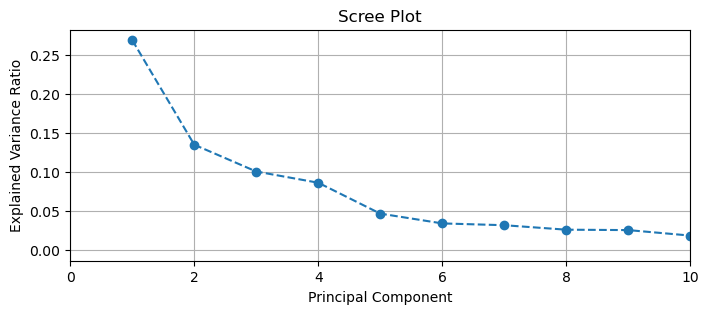

In [11]:
#Plot PCA scree plot
plt.figure(figsize=(8, 3))
plt.plot(
    range(1, len(gsas_explained_variance) + 1),
    gsas_explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xlim(0, 10)
plt.grid()
plt.show()

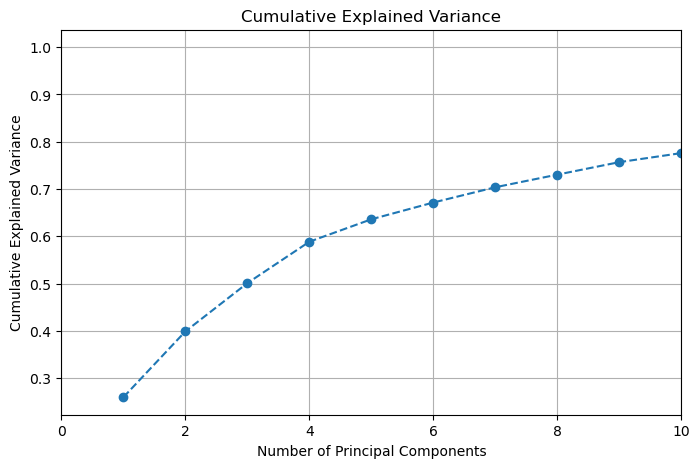

In [23]:
# Culmulative explained variance
cumulative_variance = gsas_explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.xlim(0, 10)
plt.grid()
plt.show()

#### <u>Extract the top 5 features from each PC, plot features on corr plots to explore groupings in dataset</u>

PC1: ['TFe2O3', 'SiO2', 'Co', 'Mn', 'Sc']
PC1 Loadings:
  Sc: 0.1155
  Co: 0.0823
  SiO2: -0.0347
  Mn: 0.0264
  TFe2O3: -0.0200

PC2: ['Nb', 'Ta', 'Sn', 'Zr', 'Hf']
PC2 Loadings:
  Hf: -0.1086
  Nb: 0.1043
  Ta: -0.0430
  Zr: -0.0395
  Sn: -0.0336

PC3: ['Ru', 'Ir', 'Os', 'Rh', 'Ni']
PC3 Loadings:
  Ni: 0.2911
  Ru: 0.1206
  Os: -0.0627
  Rh: -0.0555
  Ir: 0.0041

PC4: ['Cu', 'Te', 'Ag', 'Zn', 'Bi']
PC4 Loadings:
  Cu: -0.0299
  Bi: 0.0276
  Te: 0.0226
  Zn: -0.0178
  Ag: 0.0154



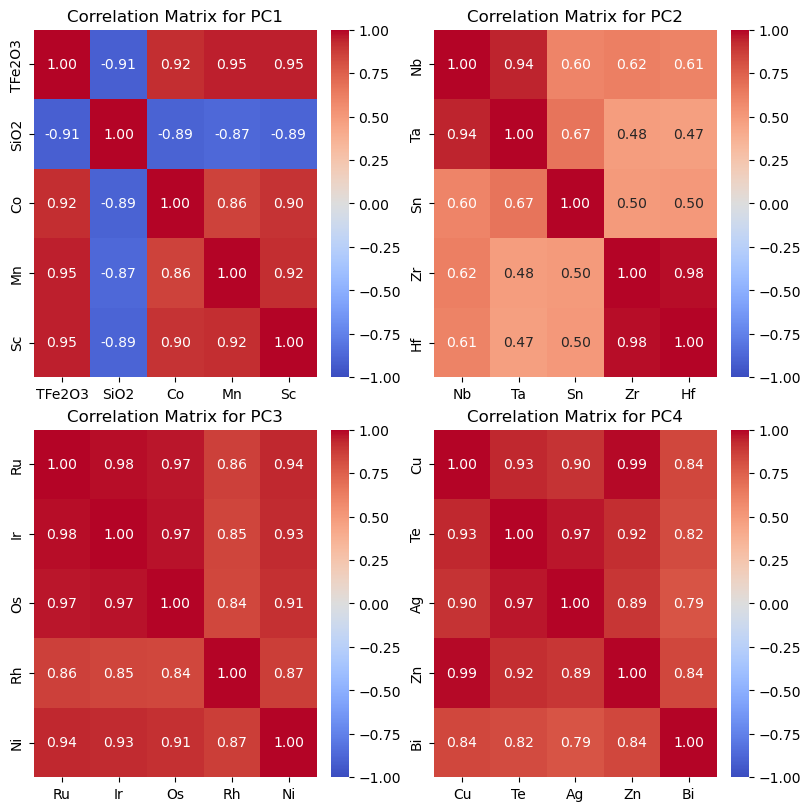

In [28]:
### Extract top features per PC

# Set parameters
num_pcs = 4  # Number of PCs to analyze
top_features_per_pc = 5  # Number of top features to extract per PC

# Prepare lists for groups of features
groups = {}

# Iterate through each PC and extract top features
for pc_index in range(num_pcs):
    # Extract feature contributions for the current PC
    contributions = pd.DataFrame(
        {
            "Feature": gsas_data_pca.columns,
            f"PC{pc_index + 1} Contribution": np.abs(pca.components_[pc_index]),
        }
    )
    # Sort by contribution and select top features
    top_features = contributions.nlargest(
        top_features_per_pc, f"PC{pc_index + 1} Contribution"
    )["Feature"].tolist()
    groups[f"PC{pc_index + 1}"] = top_features

# Display groups of correlated features
for pc, features in groups.items():
    pc_index = int(pc.replace("PC", "")) - 1
    print(f"{pc}: {features}")

    # Pair the loadings with their feature names
    feature_loadings = list(zip(features, pca.components_[pc_index]))

    # Sort by absolute loading values (highest contribution)
    sorted_features = sorted(feature_loadings, key=lambda x: abs(x[1]), reverse=True)

    # Display the top 5 loadings
    print(f"{pc} Loadings:")
    for feature, loading in sorted_features[:5]:
        print(f"  {feature}: {loading:.4f}")
    print()


## Plot

# Number of PC groups
num_groups = len(groups)

# Calculate rows and columns for square-like layout
cols = math.ceil(math.sqrt(num_groups))
rows = math.ceil(num_groups / cols)

# Create a grid of subplots
fig, axes = plt.subplots(
    rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True
)

# Flatten the axes array for easy iteration (handles cases where rows > 1)
axes = axes.flatten()

# Iterate through the groups and plot each correlation matrix on a subplot
for idx, (pc, features) in enumerate(groups.items()):
    corr_matrix = gsas_data_pca[features].corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        ax=axes[idx],
    )
    axes[idx].set_title(f"Correlation Matrix for {pc}")

# Hide any unused subplots
for ax in axes[num_groups:]:
    ax.axis("off")

# Show the final plot with all subplots
plt.show()

#### *Findings from PCA corr plots*

- <u>PC1:</u>
    - Fe2O3 typically felsic...
    - Co, Sc, Mn all mafic, correlated
    - SiO2 felsic, anti-correlated
    - Positive mafic loadings
    - *Represents mafic/felsic index: higher values = more mafic*

- <u>PC2:</u>
    - Zr/Nb/Hf/Ta all HFSEs, enriched in melt fractionation
    - Indicitave of pegmatites
    - Negative pegmatitic loadings
    - *Represents fractionation/pegmatitic trends: lower values = more pegmatitic*

- <u>PC3:</u>
    - Os/Ir/Ru all PGEs, found in orthomagmatic deposits
    - Ni also found in orthomag deposits
    - Cr found in mafic/ultramafic deposits
    - Mostly positive PGE loadings, less clear... 
    - *Represents mafic PGE intrusion systems, higher values = PGE-rich sulfide systems*

- <u>PC4:</u>
    - Bi/Ag/Zn/Cu all major polymetallic deposit indicators
    - Te also found in polymetallic deposits
    - Association with hydrothermal systems?
    - Ag/Te/Bi positive loadings, associated with hydrothermal, Cu/Zn negative loadings, associated with VMS
    - *Represents polymetallic hydrothermal - sulfide systems: higher values = hydrothermal polymetallic, low values = base metal sulfides (VMS deposits)*

<br />
<br />
Broadly, PC1 indicates that mafic/felsic variation is the greatest variable across the region. PC2 indicates that there may be pegmatitic intrusions but that they aren't quite as localized/acute, and may vary geochemically. PC 3 shows that there may strong locally specific mafic regions of mineralization rich in PGEs. PC4 shows a similar result of possible localized hydrothermal or polymetallic deposits, which is inverse of possible sulfide VMS deposits. 
<br />
<br />
Compared to the other dataset, the presence of pegmatitic indicators rather than REEs is a product of surficial weathering processes. These pegmatitic indicators are more prone to alteration during weathering, while REEs are chemically immobile and remain preserved in surficial samples. Hardrock analysis gives more bulk rock composition trends, while surficial samples have been affected by weathering and can emphasize things like REEs or other chemically immobile elements.

***

#### *Cluster PCA Results, plot*

c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


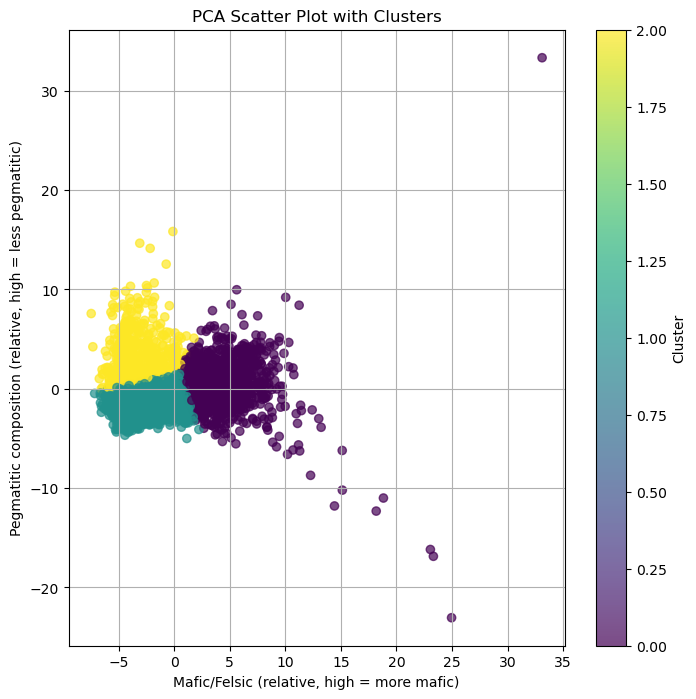

In [32]:
# Perform clustering on the PCA results (e.g., using the first 2 PCs)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df[["PC1", "PC2"]])

# Add cluster labels to the PCA DataFrame
pca_df["Cluster"] = clusters

# Visualize clusters on the PCA scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"], cmap="viridis", alpha=0.7
)
plt.title("PCA Scatter Plot with Clusters")
plt.xlabel("Mafic/Felsic (relative, high = more mafic)")
plt.ylabel("Pegmatitic composition (relative, high = less pegmatitic)")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

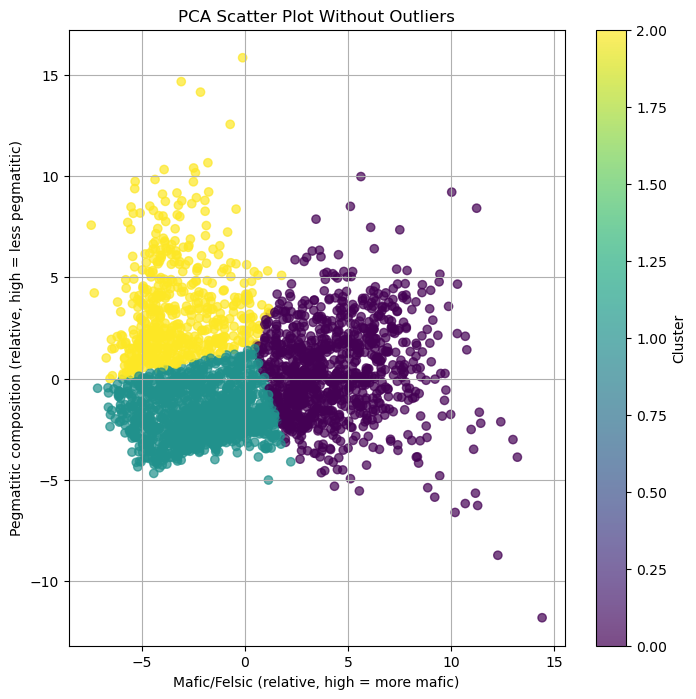

In [33]:
# Define thresholds for PC1 (HREE concentration) and PC2 (mafic/felsic)
pc1_threshold = 15  # Keep samples with PC1 < n
pc2_threshold = 20  # Keep samples with PC2 < n

# Filter out outliers
filtered_data = pca_df[
    (pca_df["PC1"] < pc1_threshold) & (pca_df["PC2"] < pc2_threshold)
]

# Replot without outliers
plt.figure(figsize=(8, 8))
plt.scatter(
    filtered_data["PC1"],
    filtered_data["PC2"],
    c=filtered_data["Cluster"],
    cmap="viridis",
    alpha=0.7,
)
plt.colorbar(label="Cluster")
plt.title("PCA Scatter Plot Without Outliers")
plt.xlabel("Mafic/Felsic (relative, high = more mafic)")
plt.ylabel("Pegmatitic composition (relative, high = less pegmatitic)")
plt.grid()
plt.show()

---

#### <u>Iterative Testing of # clusters for k-means on raw (non-PCA) dataset</u>

c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:142

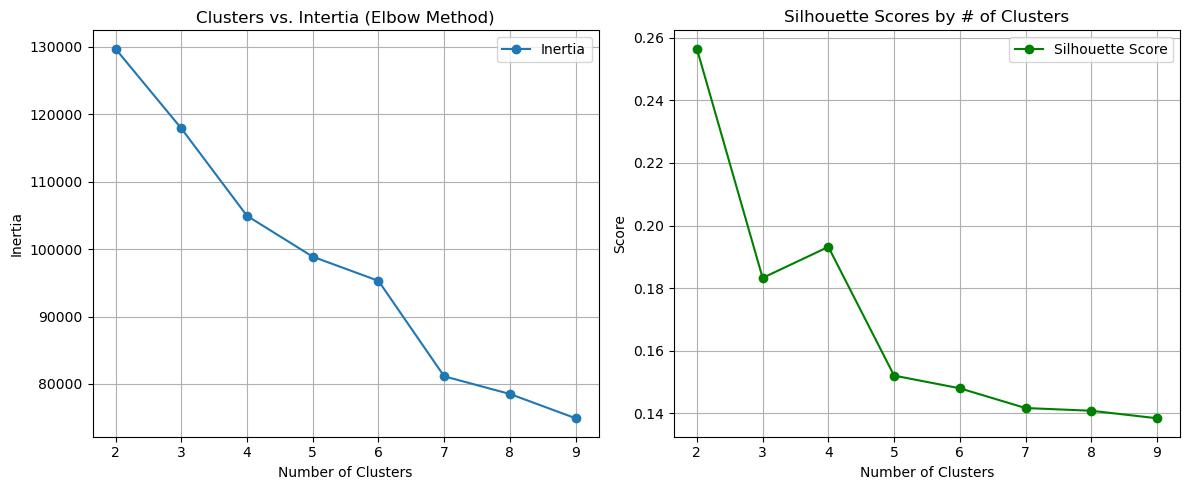

In [15]:
# Step 1: Preprocessing - Select numeric geochemical data and standardize
gsas_data_numeric = gsas_data.iloc[:, 5:].copy()  # Exclude non-numeric columns
gsas_data_numeric = gsas_data_numeric.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric
scaler = StandardScaler()
gsas_data_scaled2 = scaler.fit_transform(gsas_data_numeric)

# Step 2: Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette = []

for k in range(2, 10):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gsas_data_scaled2)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(gsas_data_scaled2, kmeans.labels_))

# Plot Inertia (Elbow) and Silhouette Scores
plt.figure(figsize=(12, 5))

# Inertia (Elbow)
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker="o", label="Inertia")
plt.title("Clusters vs. Intertia (Elbow Method)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette, marker="o", label="Silhouette Score", color="green")
plt.title("Silhouette Scores by # of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Appears that the elbow method isn't really applicable here... shows why it isn't as versatile as silhouette score. Silhouette seems to favor 2-3, need to balance score vs. over-simplifying data...  *4 clusters is too many. 

---

#### *Perform k-means clustering using optimal number of clusters*

In [20]:
# Step 3: Perform K-means clustering on pre-PCA data with optimal number of clusters (e.g., k=3)
gsas_optimal_k = 3  # Based on the elbow plot
gsas_kmeans = KMeans(n_clusters=gsas_optimal_k, random_state=42)
gsas_clusters = gsas_kmeans.fit_predict(gsas_data_scaled2)

# Step 4: Convert scaled data back to a DataFrame
gsas_data_scaled_df = pd.DataFrame(
    gsas_data_scaled2, columns=gsas_data_numeric.columns
)  # Use original column names
gsas_data_scaled_df["Cluster"] = gsas_clusters  # Add cluster assignments

# Step 5: Analyze clustering results
print('Clustering Complete\n.............\n')
print(
    gsas_data_scaled_df.groupby("Cluster").mean()
)  # Compare mean geochemical values for each cluster

Clustering Complete
.............

               Br        Cl        Cr        Hf         P        Rb        Ti  \
Cluster                                                                         
0       -0.523116 -0.263599 -0.255798  0.716077 -0.649711  1.509273 -0.684672   
1       -0.013318  0.091479 -0.161934 -0.476637 -0.240000 -0.340747 -0.433687   
2        0.335070  0.045719  0.358734  0.161864  0.696361 -0.491276  0.960510   

               Zr      SiO2     Al2O3  ...        Ag         B        Sn  \
Cluster                                ...                                 
0        0.748898  0.839317 -0.357949  ... -0.113243 -0.335028  0.612600   
1       -0.480035  0.432249  0.113096  ... -0.074730 -0.248769 -0.493485   
2        0.146151 -1.052823  0.076034  ...  0.162626  0.515839  0.245968   

                F         N         S        TC       LOI      TiO2  \
Cluster                                                               
0       -0.205355 -0.360657 -0.09983

c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


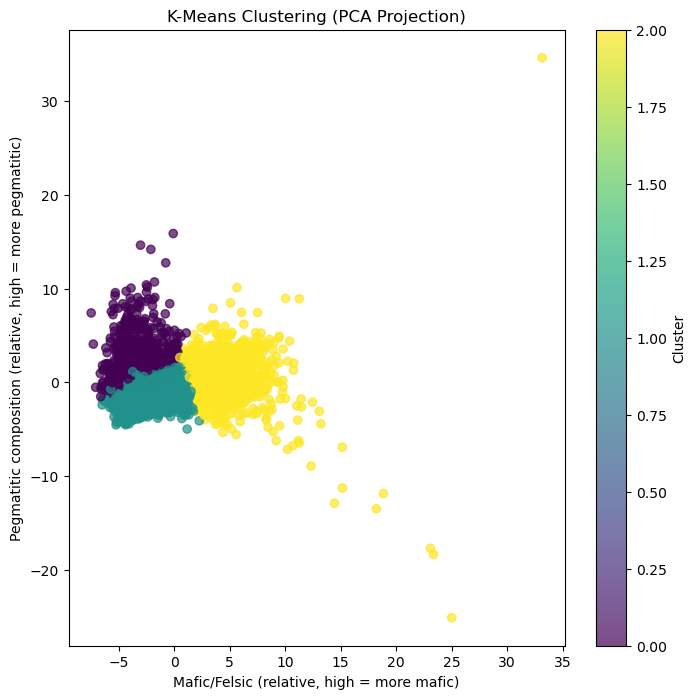

In [ ]:
# Reduce dimensions with PCA for visualization
pca2 = PCA(n_components=3)
gsas_data_pca2 = pca2.fit_transform(gsas_data_scaled2)

# Plot clusters
PC1 = 0
PC2 = 1

plt.figure(figsize=(8, 8))
plt.scatter(gsas_data_pca2[:, PC1], gsas_data_pca2[:, PC2], c=gsas_clusters, cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering (PCA Projection)")
#plt.xlabel(f"PC{PC1+1}")
#plt.ylabel(f"PC{PC2+1}")
plt.xlabel("Mafic/Felsic (relative, high = more mafic)")
plt.ylabel("Pegmatitic composition (relative, low = more pegmatitic)")
plt.colorbar(label="Cluster")
plt.show()

---

#### <u>Spatial Investigation of k-means clustered data</u>

In [22]:
### Spatial Investigation

gsas_data_spatial = gsas_data.iloc[:, 1:].copy()  
gsas_data_spatial = gsas_data_spatial.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric

# Convert the DataFrame to a GeoDataFrame
gsas_data_spatial["geometry"] = gsas_data_spatial.apply(
    lambda row: Point(row["Longitude"], row["Latitude"]), axis=1
)
gsas_geo_data = gpd.GeoDataFrame(
    gsas_data_spatial, geometry="geometry", crs="EPSG:4326"
)  # WGS84 CRS
gsas_geo_data["Cluster"] = gsas_clusters

# Inspect the GeoDataFrame
# print(gsas_geo_data.head())
# print(gsas_geo_data["Cluster"].unique())
print(gsas_geo_data.total_bounds)
print(gsas_geo_data.isnull().sum())
print(gsas_geo_data.crs)

[42.00003917 19.000001   43.49976283 20.00004167]
Smaple Code          2728
Lab Sample Number    2728
Longitude               0
Latitude                0
Br                      0
                     ... 
LOI                     0
TiO2                    0
Al2O3/TiO2              0
geometry                0
Cluster                 0
Length: 65, dtype: int64
EPSG:4326


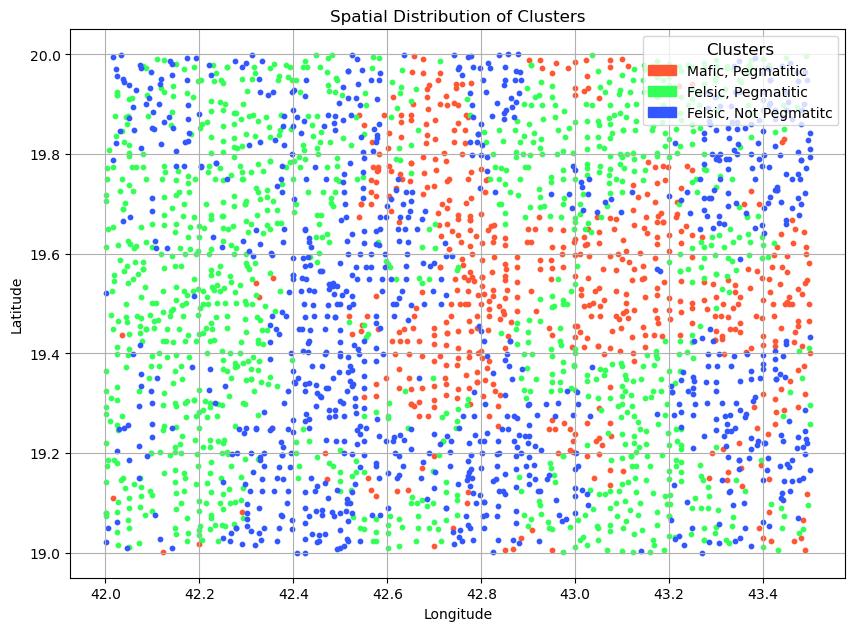

In [29]:
### Spatial Analysis

# Custom cluster colors (ensure consistency with the plot)
cluster_colors = {
    0: "#FF5733",
    1: "#33FF57",
    2: "#3357FF",
}  # Vibrant colors for clusters

# Add a 'Color' column to GeoDataFrame
gsas_geo_data["Color"] = gsas_geo_data["Cluster"].map(cluster_colors)

# Define new names for the clusters
cluster_names = {0: "Mafic, Pegmatitic", 1: "Felsic, Pegmatitic", 2: "Felsic, Not Pegmatitc"}

# Add a new column to the GeoDataFrame with descriptive cluster names
gsas_geo_data["Cluster_Name"] = gsas_geo_data["Cluster"].map(cluster_names)

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 8))
for cluster, color in cluster_colors.items():
    subset = gsas_geo_data[gsas_geo_data["Cluster"] == cluster]
    subset.plot(ax=ax, color=color, markersize=10, label=f"Cluster {cluster}", aspect='auto')

# Add a categorical legend (aligned with cluster colors)
handles = [
    mpatches.Patch(color=color, label=cluster_names[cluster])
    for cluster, color in cluster_colors.items()
]
plt.legend(
    handles=handles, title="Clusters", loc="upper right", fontsize=10, title_fontsize=12
)

# Add titles and labels
plt.title("Spatial Distribution of Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

#### *Interpolate points into continuous categorical map*

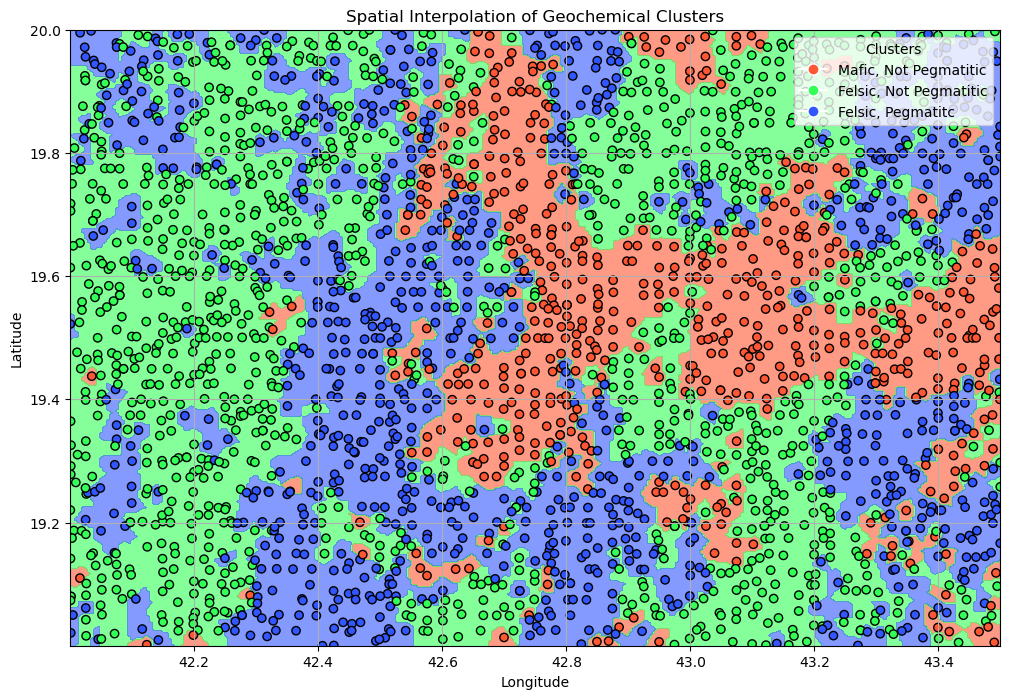

In [24]:
# Extract spatial coordinates and cluster labels
x = gsas_geo_data["Longitude"].values
y = gsas_geo_data["Latitude"].values
z = gsas_geo_data["Cluster"].values  # Cluster labels

# Define the grid for interpolation
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),  # Adjust resolution
    np.linspace(y.min(), y.max(), 300),
)

# Perform nearest neighbor interpolation
zi = griddata((x, y), z, (xi, yi), method="nearest")

# Use your custom colors for the clusters
custom_cmap = ListedColormap([cluster_colors[i] for i in sorted(cluster_colors.keys())])

# Plot the interpolated clusters
plt.figure(figsize=(12, 8))
plt.contourf(
    xi,
    yi,
    zi,
    levels=np.arange(len(cluster_colors) + 1) - 0.5,
    cmap=custom_cmap,
    alpha=0.6,
)
#plt.colorbar(ticks=range(len(cluster_colors)), label="Cluster")  # Add a colorbar
plt.scatter(
    x, y, c=z, cmap=custom_cmap, edgecolor="k", label="Sample Points"
)  # Overlay sample points
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Interpolation of Geochemical Clusters")
plt.legend(
    handles=[
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=cluster_names[cluster],
            markersize=8,
            markerfacecolor=color,
        )
        for cluster, color in cluster_colors.items()
    ],
    title="Clusters",
    loc="upper right",
)
plt.grid()
plt.show()